Implementation of the standard isochron method emplyoed by ISOPLOT (e.g. Ludwig, 2003) as defined in York 1966, 1969 York et al. 2014. The method uses two measured variables with correlated errors.

<!--more-->

In [1]:
from pprint import pprint
from collections import namedtuple

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl

from errorellipse import error_ellipse

In [2]:
Yorkfit = namedtuple('Yorkfit', ['y0', 'alpha', 
                                 'y0_err', 'alpha_err',
                                 'MSWD', 'deg_f', 
                                 'x_adj', 'y_adj'])

In [3]:
def york(X, Y, X_err, Y_err, rho=None, max_iter=1000, epsilon=1e-18):
    if rho is None:
        rho = 0*X
    elif type(rho) is float:
        rho = np.ones(X.shape)*rho

    # Step 1 estimate b
    b = stats.linregress(X, Y).intercept

    # Step 2 calculate weights
    w_X =  1/X_err**2
    w_Y =  1/Y_err**2

    # Iterate over step 3-6
    for i in range(max_iter):
        # Step 3 evaluate W
        alpha = (w_X*w_Y)**0.5
        W = (w_X*w_Y) / (w_X + w_Y*b**2 - 2*b*rho*alpha)

        # Step 4 Calculate X_bar, Y_bar -> U_i V_i beta_i
        X_bar = sum(W*X)/sum(W)
        Y_bar = sum(W*Y)/sum(W)
        U = X - X_bar
        V = Y - Y_bar
        beta = W * (U/w_Y + b*V/w_X -(b*U+V)*rho/alpha)

        # Step 5
        b_prev = b
        b = sum(W*beta*V)/sum(W*beta*U)

        # Step 6 Iterate if new estimate is worse than desired level
        if abs(b-b_prev) < epsilon:
#             print('iterations', i)
            break

    # Step 7 calculate a
    a = Y_bar - b*X_bar

    # Step 8 calculate adjusted values x and y
    x = X_bar + beta
    y = Y_bar + b*beta

    # Step 9 calculate x_bar and u
    x_bar = sum(W*x)/ sum(W)
    y_bar = sum(W*y)/ sum(W)
    u = x - x_bar
    v = y - y_bar
    

    # Step 10 calculate sigma a and sigma b
    sigma_b = 1/(sum(W*u**2))
#     print(W, u, u**2, sep='\n')
    sigma_a = 1/sum(W) + x_bar**2 * sigma_b


    # Step 11 calculate goodness of fit
    # S = sum(w_Xu**2)
    S = sum(W *(Y-b*X-a)**2)
    # S = sum(u**2 / )
    deg_f = len(X) - 1
    MSWD = S/deg_f
    return Yorkfit(a, b, sigma_a**0.5, sigma_b**0.5, MSWD, deg_f, x, y)

## Decay model parameters

Decay constants in y<sup>-1</sup> from Steiger and Jäger (1977)

In [4]:
lambda_232_Th = 0.049475e-9
lambda_238_1 =  0.155125e-9
lambda_235_2 =  0.98485e-9

Initial composition for common lead (Tatsumoto 1973)

In [5]:
Pb206Pb204_CD = 9.307
Pb207Pb204_CD = 10.294
Pb208Pb204_CD = 29.476

## Decay models for lead evolution

In [6]:
Pb207206star = lambda t: 1/137.88 * (np.exp(lambda_235_2*t)-1)/(np.exp(lambda_238_1*t)-1)

Stacey and Kramers (1975) two stage lead evolution 

In [7]:
Pb206Pb204_SK_2 = lambda t: 11.152 + 9.735 *(np.exp(lambda_238_1*3.7e9)-np.exp(lambda_238_1*t))
Pb207Pb204_SK_2 = lambda t: 12.998 + 9.735/137.88 * (np.exp(lambda_235_2*3.7e9)-np.exp(lambda_235_2*t))

Pb206Pb204_SK_mu = lambda mu:(lambda t: 11.152 + mu *(np.exp(lambda_238_1*3.7e9)-np.exp(lambda_238_1*t)))
Pb207Pb204_SK_mu = lambda mu:(lambda t: 12.998 + mu/137.88 * (np.exp(lambda_235_2*3.7e9)-np.exp(lambda_235_2*t)))


Pb206Pb204_1s = lambda mu:(lambda t: Pb206Pb204_CD + mu *(np.exp(lambda_238_1*4.57e9)-np.exp(lambda_238_1*t)))
Pb207Pb204_1s = lambda mu:(lambda t: Pb207Pb204_CD + mu/137.88 * (np.exp(lambda_235_2*4.57e9)-np.exp(lambda_235_2*t)))


## Example

Intercept: -0.004427323544156314 ± 0.011174410169326278
Slope: 1.0149716953160086 ± 0.02263602489255625
MSWD: 2.905814608188555


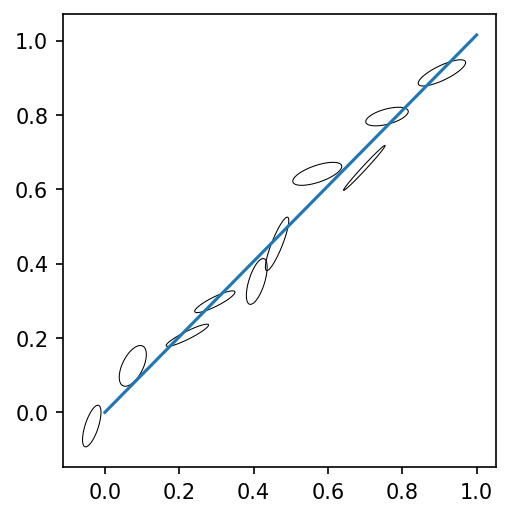

In [9]:
fig, ax = plt.subplots(dpi=150)
ax.set_aspect('equal')

rng = np.random.RandomState(938262)
X = np.array([i/10 + (rng.rand()-0.5)/10 for i in range(10)])
Y = np.array([i/10+(rng.rand()-0.5)/10 for i in range(10)])
X_err = np.array([0.01+rng.rand()/50 for _ in range(10)])
Y_err = np.array([0.01+rng.rand()/50 for _ in range(10)])
Rho = np.array([0.7*rng.rand() + 0.2 for _ in range(10)])

for PT in zip(X, Y, X_err, Y_err, Rho):
    e_coords = error_ellipse(*PT)
    e = mpl.patches.Polygon(e_coords, fc='none', ec='k', lw=0.5, joinstyle='round')
    ax.add_patch(e)

fit = york( X, Y, X_err, Y_err, Rho)
print("Intercept: {} ± {}".format(fit.y0, fit.y0_err),
      "Slope: {} ± {}".format(fit.alpha, fit.alpha_err),
      "MSWD: {}".format(fit.MSWD),
      sep='\n',
)
ax.plot([0,1],[0,fit.alpha]);
plt.savefig('output_13_1.png');

## References
<hb>
    
Ludwig, K. R. (2003). User's manual for IsoPlot 3.0. A geochronological toolkit for Microsoft Excel, 71.

Stacey, J.S., Kramers, J.D. (1975) Approximation of terrestrial lead isotope evolution by a two-stage model. Earth and Planetary Science Letters 26, 207-221.
    
Steiger, R.H. and Jäger, E. (1977) Subcommission on Geochronology: Convention on the use of decay constants in geo- and cosmochronology. Earth and Planetary Science Letters 36, 359-362.

Tatsumoto, M., Knight R.J., Allègre, C.J. (1973) Time differences in the formation of meteorites as determined from the ratio of lead-207 to lead-206. Science 180, 1279-1283. 
    
York, D. (1966) Least squares fitting of a straight line. Canadian Journal of Physics, 44, 1079–1086.

York, D. (1969) Least squares fitting of a straight line with correlated errors. Earth and Planetary Science Letters 5, 320–324.

York, D., Evensen, N.M., Martinez, M.L., and Delgado, J.D. (2004) Unified equations for the slope, intercept, and standard errors of the best straight line. American Journal of Physics 72, 367–375.